### Main imports

In [69]:
import os
import requests
from tqdm import tqdm
import zipfile
import numpy
import torch
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Imports complete.')

Imports complete.


### Download dataset

In [70]:
# URL of the file
url = 'https://data.ncl.ac.uk/ndownloader/articles/24574354/versions/1'

# make directory if it doesn't exist
directory = 'classification-data'
if not os.path.exists(directory):
    os.makedirs(directory)

# where to save the downloaded file
file_path = os.path.join(directory, 'downloaded_file.zip')

# send a GET request to the URL with stream=True for chunked download
response = requests.get(url, stream=True)

# check if the request was successful
if response.status_code == 200:
    # total size in bytes from the header
    total_size = int(response.headers.get('content-length', 0))

    # progress bar
    with open(file_path, 'wb') as file, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
    ) as progress_bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
                progress_bar.update(len(chunk))

    print("File downloaded successfully!")

    # unzipping
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(directory)
        print(f"Files unzipped successfully in the '{directory}' directory!")

    # remove the zip file after extraction
    os.remove(file_path)
    print("Zip file removed after extraction.")

else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Downloading: 100%|██████████| 629M/629M [07:05<00:00, 1.55MB/s]    


File downloaded successfully!
Files unzipped successfully in the 'classification-data' directory!
Zip file removed after extraction.


### Import dataset

In [71]:
import os
import numpy
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# directory where the data is stored
data_dir = 'classification-data'

# the .npy files
train_x_path = os.path.join(data_dir, 'train_x.npy')
train_y_path = os.path.join(data_dir, 'train_y.npy')
valid_x_path = os.path.join(data_dir, 'valid_x.npy')
valid_y_path = os.path.join(data_dir, 'valid_y.npy')
test_x_path = os.path.join(data_dir, 'test_x.npy')
test_y_path = os.path.join(data_dir, 'test_y.npy')

# load the data
print("Loading data...")
train_x = numpy.load(train_x_path)
train_y = numpy.load(train_y_path)
valid_x = numpy.load(valid_x_path)
valid_y = numpy.load(valid_y_path)
test_x = numpy.load(test_x_path)
test_y = numpy.load(test_y_path)
print("Data loaded successfully.")

print("Shape of one training sample:", train_x.shape[1:])
print("Shape of one validation sample:", valid_x.shape[1:])
print("Shape of one test sample:", test_x.shape[1:])

train_x = train_x.reshape(-1, 3, 28, 28) 
valid_x = valid_x.reshape(-1, 3, 28, 28) 
test_x = test_x.reshape(-1, 3, 28, 28)

print("Shape of one training sample:", train_x.shape[1:])
print("Shape of one validation sample:", valid_x.shape[1:])
print("Shape of one test sample:", test_x.shape[1:])

# convert NumPy arrays to PyTorch tensors - HAS BEEN CHANGED FOR THE ABOVE
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
valid_x = torch.from_numpy(valid_x).float()

valid_y = torch.from_numpy(valid_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

# create TensorDataset instances
train_dataset = TensorDataset(train_x, train_y)
valid_dataset = TensorDataset(valid_x, valid_y)
test_dataset = TensorDataset(test_x, test_y)

# batch size
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Helper function to cycle through the data indefinitely
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# iterators for training, validation, and test loaders
train_iterator = iter(cycle(train_loader))
valid_iterator = iter(cycle(valid_loader))
test_iterator = iter(cycle(test_loader))

# class names
class_names = [str(i) for i in range(20)]

# dataset sizes
print(f'> Size of training dataset: {len(train_dataset)}')
print(f'> Size of validation dataset: {len(valid_dataset)}')
print(f'> Size of test dataset: {len(test_dataset)}')


Loading data...
Data loaded successfully.
Shape of one training sample: (3, 28, 28)
Shape of one validation sample: (3, 28, 28)
Shape of one test sample: (3, 28, 28)
Shape of one training sample: (3, 28, 28)
Shape of one validation sample: (3, 28, 28)
Shape of one test sample: (3, 28, 28)
> Size of training dataset: 45000
> Size of validation dataset: 15000
> Size of test dataset: 10000


**View some of the test dataset**

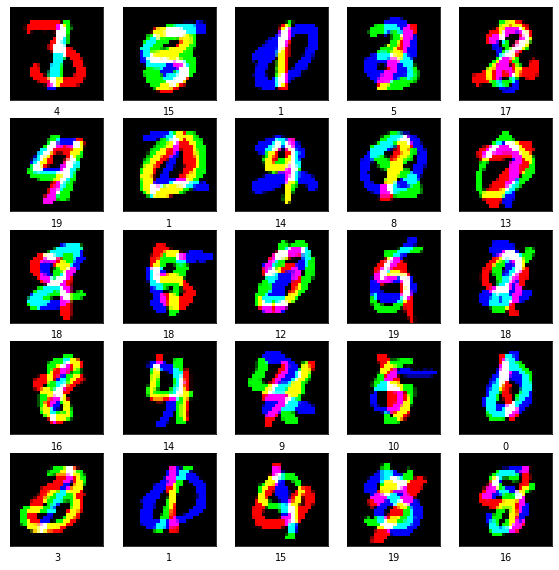

In [72]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    img = numpy.clip(img, 0, 1)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

### Attempt 1 - 80% accuracy

In [176]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16,kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 20)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2) 
        x = F.relu(self.conv2(x))
        x = self.bn2(x) 
        x = F.max_pool2d(x, 2) 
        x = F.relu(self.conv3(x)) 
        x = self.bn3(x)
        x = F.max_pool2d(x, 2) 
        x = F.relu(self.conv4(x)) 
        x = self.bn4(x)
        x = F.max_pool2d(x, 2) 

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x.view(x.size(0), -1)

N = EnhancedCNN().to(device)

print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

criterion = nn.CrossEntropyLoss()

optimiser = torch.optim.AdamW(N.parameters(), lr=0.001, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.2, patience=7)


plot_data = []
steps = 0
best_test_acc = 0.0


> Number of parameters 83860


### Attempt 2 - N/A

In [144]:
class EnhancedCNN(nn.Module):
    def __init__(self):
            super(EnhancedCNN, self).__init__()
            self.conv1 = nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
            
            self.conv2 = nn.Sequential(nn.Conv2d(8, 16, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))

            self.conv3 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))

            self.conv4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))


            self.fc1 = nn.Linear(64, 256)
            self.fc2 = nn.Linear(256, 128)
            self.fc3 = nn.Linear(128, 64)
            self.fc4 = nn.Linear(64, 32)
            self.fc5 = nn.Linear(32,20)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

N = EnhancedCNN().to(device)

print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

criterion = nn.CrossEntropyLoss()

optimiser = torch.optim.AdamW(N.parameters(), lr=0.001, weight_decay=0.01)

scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=7, gamma=0.01)

plot_data = []
steps = 0


> Number of parameters 85300


### Main training and testing loop - Attempt 1

steps: 10000.00, train loss: 0.562, train acc: 0.826±0.049, test acc: 0.752±0.055


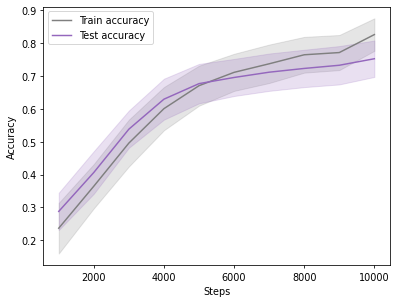

In [177]:
# keep within our optimisation step budget
while (steps < 10000):

    # arrays for metrics
    train_loss_arr = numpy.zeros(0)
    train_acc_arr = numpy.zeros(0)
    test_acc_arr = numpy.zeros(0)

    # iterate through some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        
        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = criterion(p, t)
        loss.backward()
        optimiser.step()
        steps += 1

        train_loss_arr = numpy.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = numpy.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # scheduler.step()

    # iterate over the entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N(x)
        loss = criterion(p,t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = numpy.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    avg_train_loss = numpy.mean(train_loss_arr)
    avg_train_acc = numpy.mean(train_acc_arr)
    avg_test_acc = numpy.mean(test_acc_arr)

    scheduler.step(avg_test_acc)

    if avg_test_acc > best_test_acc:
        best_test_acc = avg_test_acc
        torch.save(N.state_dict(), 'best_model.pth')

    # print your loss and accuracy data - include this in the final report
    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(),train_acc_arr.mean(),train_acc_arr.std(),test_acc_arr.mean(),test_acc_arr.std()))

    # plot your accuracy graph - add a graph like this in your final report
    plot_data.append([steps, numpy.array(train_acc_arr).mean(), numpy.array(train_acc_arr).std(), numpy.array(test_acc_arr).mean(), numpy.array(test_acc_arr).std()])
    reward_list = []
    plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    disp.clear_output(wait=True)

## Inference on data

This is useful for analysis but is entirely optional

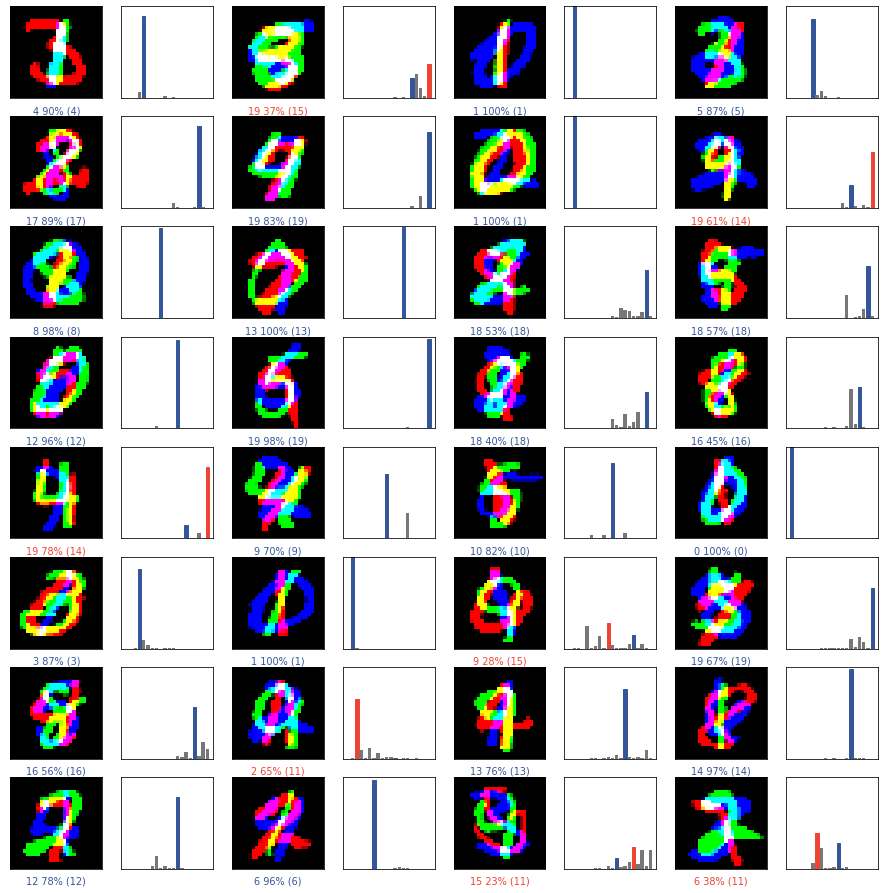

In [76]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    img = numpy.clip(img, 0, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = numpy.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = numpy.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*numpy.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(20), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = numpy.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())